<h2>Finding the Best Beers to Try in BeerAdvocate Data</h2>

I'll analyze an existing dataset from BeerAdvocate consisting of beer reviews to find the best beers to recommend. To make my recommendations, I'll try to find out:
<ol>
    <li>Which brewery produces the strongest beers by ABV%?</li>
    <li>Which of the factors (aroma, taste, appearance, palate) are most important in determining the overall quality of a beer?</li>
    <li>What can we say about reviewers?</li>
    <li>If you had to pick up only 3 beers to recommend using only this data, which would you pick?</li>
</ol>
<h4>Summary of Results</h4>
After analyzing the data, I found out that:
<ul>
    <li>the taste of beer is the most important factor in determining the overall quality;</li>
    <li>the strongest beer has 57.70% abv, but overall reviews for the strongest beers are not very high;</li>
    <li>half of reviewers tried at least 3 different beer styles and wrote at least 3 reviews.</li><br>
For more details, please refer to the the full analysis below.

<h3>1. Import libraries and data</h3>
The dataset is publicly available <a href="https://data.world/socialmediadata/beeradvocate">in data.world repository</a>.<br>
Let's start with importing libraries, reading a file with data to a Pandas Dataframe and doing a quick exploration.

In [129]:
#import libraries
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#use seaborn styles for graphs
sns.set_palette("GnBu_d")
sns.set()

#import data
df = pd.read_csv('beer_reviews.csv')
df.head()

,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid
0,10325,Vecchio Birraio,1234817823,1.5,2.0,2.5,stcules,Hefeweizen,1.5,1.5,Sausa Weizen,5.0,47986
1,10325,Vecchio Birraio,1235915097,3.0,2.5,3.0,stcules,English Strong Ale,3.0,3.0,Red Moon,6.2,48213
2,10325,Vecchio Birraio,1235916604,3.0,2.5,3.0,stcules,Foreign / Export Stout,3.0,3.0,Black Horse Black Beer,6.5,48215
3,10325,Vecchio Birraio,1234725145,3.0,3.0,3.5,stcules,German Pilsener,2.5,3.0,Sausa Pils,5.0,47969
4,1075,Caldera Brewing Company,1293735206,4.0,4.5,4.0,johnmichaelsen,American Double / Imperial IPA,4.0,4.5,Cauldron DIPA,7.7,64883


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1586614 entries, 0 to 1586613
Data columns (total 13 columns):
brewery_id            1586614 non-null int64
brewery_name          1586599 non-null object
review_time           1586614 non-null int64
review_overall        1586614 non-null float64
review_aroma          1586614 non-null float64
review_appearance     1586614 non-null float64
review_profilename    1586266 non-null object
beer_style            1586614 non-null object
review_palate         1586614 non-null float64
review_taste          1586614 non-null float64
beer_name             1586614 non-null object
beer_abv              1518829 non-null float64
beer_beerid           1586614 non-null int64
dtypes: float64(6), int64(3), object(4)
memory usage: 157.4+ MB


The dataset consists of 1586614 entries; each entry is one review and shows what the user thinks about such beer features as taste, appearance, aroma, palate, and overall impression. Each review also has information about beer and its manufacturer.<br>
The dataset looks pretty good, but there are missing values in Brewery_name, Review_profilename, and Beer_abv columns.

In [49]:
#count missing values
print('Missing values in Brewery_name column:', df[pd.isna(df['brewery_name'])].shape[0])
print('Missing values in Review_profilename column:', df[pd.isna(df['review_profilename'])].shape[0])
print('Missing values in Beer_abv column: ', df[pd.isna(df['beer_abv'])].shape[0])

Missing values in Brewery_name column: 15
Missing values in Review_profilename column: 348
Missing values in Beer_abv column:  67785


Missing values are just a small fraction of 1.5 millions of reviews so that I can drop it.

In [51]:
#drop all missing values in dataframe
df = df.dropna()
print('Missing values in Beer_abv column: ', df[pd.isna(df['beer_abv'])].shape[0])

Missing values in Beer_abv column:  0


Let's do some quick exploration and look how much breweries, beers, reviewers are in this dataset.

In [52]:
print('Number of breweries: ',df['brewery_id'].nunique())
print('Number of beers: ', df['beer_beerid'].nunique())
print('Number of beer styles: ', df['beer_style'].nunique())
print('Number of reviewers:', df['review_profilename'].nunique())
print('Average overall impression: ', "{0:.2f}".format(df['review_overall'].mean()))

Number of breweries:  5230
Number of beers:  49000
Number of beer styles:  104
Number of reviewers: 32908
Average overall impression:  3.82


<h3>2. Beer</h3>
<h4>2.1 Beer Characteristics and Overall Quality</h4>
Let's look at how users evaluate different features of beer.

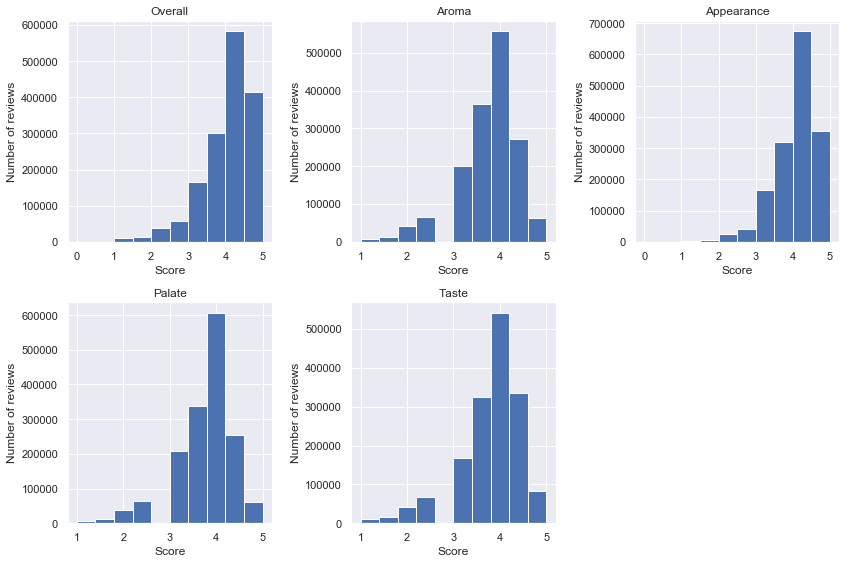

In [141]:
plt.figure(figsize=(12,8))

#Draw first suplot
plt.subplot(231)
plt.hist(df['review_overall'])
plt.title("Overall")
plt.xlabel("Score")
plt.ylabel("Number of reviews")

#Draw second subplot    
plt.subplot(232)
plt.hist(df['review_aroma'])
plt.title("Aroma")
plt.xlabel("Score")
plt.ylabel("Number of reviews")

#Draw third subplot    
plt.subplot(233)
plt.hist(df['review_appearance'])
plt.title("Appearance")
plt.xlabel("Score")
plt.ylabel("Number of reviews")

#Draw fourth subplot    
plt.subplot(234)
plt.hist(df['review_palate'])
plt.title("Palate")
plt.xlabel("Score")
plt.ylabel("Number of reviews")

#Draw fifth subplot    
plt.subplot(235)
plt.hist(df['review_taste'])
plt.title("Taste")
plt.xlabel("Score")
plt.ylabel("Number of reviews")

plt.tight_layout()
plt.show()

Distributions are skewed. We can notice that even when a person didn't like the aroma or taste their overall review is not bad.<br>
Let's now look at correlations between variable to see if some characteristics are more relevant to overall impressions.

In [130]:
#calcilate correlation matrix
calc_corr = df[['review_overall', 'review_aroma', 'review_appearance', 'review_palate', 'review_taste']]

#visualize correlation matrix
calc_corr.corr().style.background_gradient()

,review_overall,review_aroma,review_appearance,review_palate,review_taste
review_overall,1,0.616013,0.501732,0.701914,0.789816
review_aroma,0.616013,1,0.561029,0.616947,0.716776
review_appearance,0.501732,0.561029,1,0.566634,0.54698
review_palate,0.701914,0.616947,0.566634,1,0.734135
review_taste,0.789816,0.716776,0.54698,0.734135,1


The biggest correlation with Review_overall has Review_taste (0.79), the smallest - Review_appearance (0.5). 

<h4>2.2 The Strongest Beer</h4>
Let's start with distributions of beer abv.

In [131]:
#calculate average beer abv for all beers
print('Average ABV:', "{0:.2f}".format(df['beer_abv'].mean()))

Average ABV: 7.04


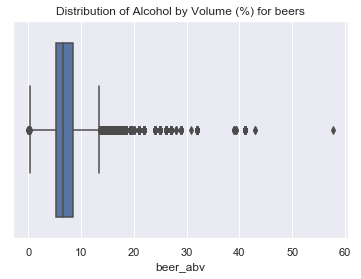

In [132]:
#plot the distribution
sns.boxplot(x=df['beer_abv'])
plt.title('Distribution of Alcohol by Volume (%) for beers')
plt.show()

As we can see average abv for all beers is 7%, and there are enough beers with really high abv. So let's look at the ten the strongest beers.

In [133]:
#sort beers by abv and show the first 10
strong_beers = df.sort_values(by=['beer_abv'], ascending=False)[['brewery_name', 'beer_style', 'beer_name', 'beer_abv']]
strong_beers.drop_duplicates().head(10)

,brewery_name,beer_style,beer_name,beer_abv
12919,Schorschbräu,Eisbock,Schorschbräu Schorschbock 57%,57.70
12939,Schorschbräu,Eisbock,Schorschbräu Schorschbock 43%,43.00
746385,BrewDog,American Double / Imperial IPA,Sink The Bismarck!,41.00
12941,Schorschbräu,Eisbock,Schorschbräu Schorschbock 40%,39.44
996153,De Struise Brouwers,American Double / Imperial Stout,Black Damnation VI - Messy,39.00
748356,BrewDog,American Double / Imperial Stout,Tactical Nuclear Penguin,32.00
12918,Schorschbräu,Eisbock,Schorschbräu Schorschbock 31%,30.86
1042328,Hair of the Dog Brewing Company / Brewery and ...,English Barleywine,Dave,29.00
746421,BrewDog,Belgian Strong Pale Ale,Ghost Deer,28.00
293821,Boston Beer Company (Samuel Adams),American Strong Ale,Samuel Adams Utopias,27.00


The strongest beer is "Schorschbräu Schorschbock 57%", it has 57.70 abv. The same brewery "Schorschbräu" brews other three strongest beers "Schorschbräu Schorschbock 43%", "Schorschbräu Schorschbock 40%", and "Schorschbräu Schorschbock 31%". "BrewDog" brewery has 3 beers among the strongest with 41, 32 and 28 abv.<br>
Let's look at how reviewers score these beers.

In [134]:
#save the names of 10 strongest beers
strongbeers = strong_beers.drop_duplicates().head(10)['beer_name'].tolist()

#leave data only about these 10 beers
strongest = df[df['beer_name'].isin(strongbeers)]

#calculate average scores for each beer
strongest.groupby(['beer_name']).mean()[['review_overall', 'review_aroma', 'review_appearance', 'review_palate']]

,review_overall,review_aroma,review_appearance,review_palate
beer_name,,,,
Black Damnation VI - Messy,4.500000,4.642857,4.857143,4.785714
Dave,4.437500,4.562500,4.375000,4.531250
Ghost Deer,3.500000,3.666667,3.000000,2.833333
Samuel Adams Utopias,4.066197,4.453521,4.198592,4.246479
Schorschbräu Schorschbock 31%,3.500000,4.000000,4.000000,4.000000
Schorschbräu Schorschbock 40%,3.333333,3.666667,3.666667,3.166667
Schorschbräu Schorschbock 43%,3.750000,4.000000,3.750000,4.000000
Schorschbräu Schorschbock 57%,4.000000,4.000000,4.000000,4.000000
Sink The Bismarck!,3.197368,3.822368,3.835526,3.401316


The strongest beer "Schorschbräu Schorschbock 57%" has not so bad overall impression, the best-rated beer from this beer is "Black Damnation VI - Messy" with overall review 4.5 and abv 39, "Tactical Nuclear Penguin" has the smallest score 3.19 and abv 32.

<h3>3. Portrait of a Beer Lover</h3>
Now let's see what data could tell about reviewers and their preferences. <br>
<h4>3.1 Popular and Unpopular Beer Styles</h4>
The highest rated beer styles include Stouts and Ales, Gueuze, and Lambic. 
Among beer styles with the lowest overall_review are mostly lagers and other low alcohol drinks like Rice Lager, Kvass, Malt Liquor. 

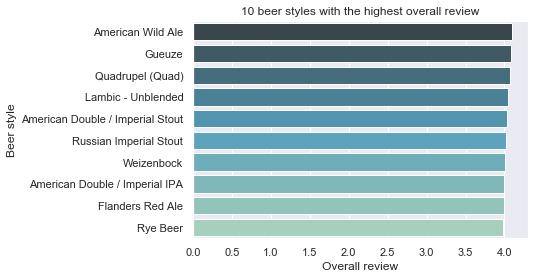

In [135]:
#leave only overall review and find average overall score for each beer style
overall = df[['brewery_name', 'beer_style', 'beer_name','review_overall']]
ov_style = overall.groupby(['beer_style']).mean().reset_index()

#plot the top 10 beer styles
sns.barplot(y='beer_style', x='review_overall', data=ov_style.sort_values('review_overall', ascending=False).head(10), palette="GnBu_d")
plt.title('10 beer styles with the highest overall review')
plt.xlabel('Overall review')
plt.ylabel('Beer style')
plt.show()

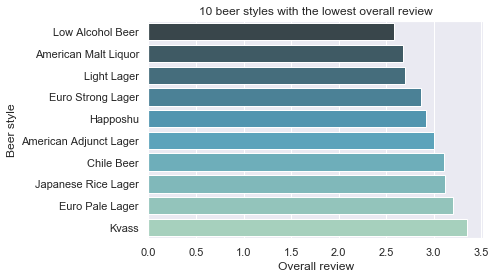

In [136]:
#plot 10 beerstyles with the lowest overall review
sns.barplot(y='beer_style', x='review_overall', data=ov_style.sort_values('review_overall', ascending=True).head(10), palette="GnBu_d")
plt.title('10 beer styles with the lowest overall review')
plt.xlabel('Overall review')
plt.ylabel('Beer style')
plt.show()

The most often are reviewed the next beer styles: American IPA, Imperial IPA, American Pale Ale and other Stouts and Ales. 

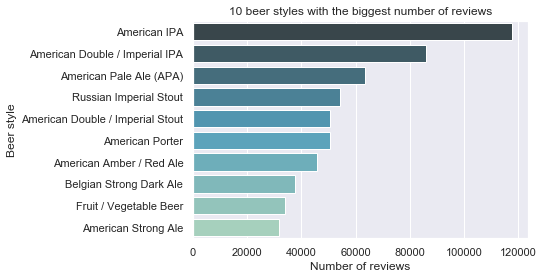

In [138]:
#What beerstyle has the most/least reviews
style_reviews = df.groupby('beer_style').count()[['review_overall']].reset_index().sort_values(by=['review_overall'], ascending=False)

sns.barplot(y='beer_style', x='review_overall', data=style_reviews.head(10), palette="GnBu_d")
plt.title('10 beer styles with the biggest number of reviews')
plt.xlabel('Number of reviews')
plt.ylabel('Beer style')
plt.show()

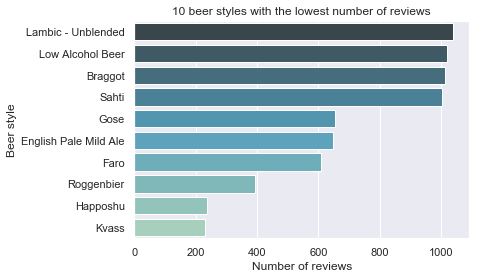

In [137]:
#plot beerstyles with the least numbers of reviews
sns.barplot(y='beer_style', x='review_overall', data=style_reviews.tail(10), palette="GnBu_d")
plt.title('10 beer styles with the lowest number of reviews')
plt.xlabel('Number of reviews')
plt.ylabel('Beer style')
plt.show()

<h4>3.2 Typical Reviewer</h4>
Let's look at reviewers profiles and count how much reviews they left.

In [139]:
#count number of reviews for each profile
profiles = df.groupby(['review_profilename']).count()[['review_overall']].reset_index()
profiles.describe()

,review_overall
count,33387.000000
mean,47.511487
std,182.599759
min,1.000000
25%,1.000000
50%,3.000000
75%,16.000000
max,5817.000000


As we can see, half of the reviewers wrote 3 and fewer reviews. 75% of users wrote up to 16 reviews. The largest number of reviews from one user is 5346!<br>
Another interesting thing is how many different styles users tried.

In [140]:
#count number of beerstyles for each profile
profiles_style = df[['review_profilename', 'beer_style']].drop_duplicates()
profiles_style = profiles_style.groupby(['review_profilename']).count().reset_index()
profiles_style.describe()

,beer_style
count,33387.00000
mean,12.05562
std,19.93837
min,1.00000
25%,1.00000
50%,3.00000
75%,12.00000
max,104.00000


Half of the reviewers tried at least three different beer styles. 75% of all users wrote reviews for 12 different styles. Also, the maximum of styles reviewed by one user is 104.

<h3>4. What Beer to Try</h3>

If you had to pick up only three beers to recommend using only this data, which would you pick?<br>
I would start with the beer style and pick three styles with the highest rating. Then for each of them, I would find the best beer, but I would only consider beers with at least 5 reviews.

In [100]:
#Top3 rated beerstyles
ov_style.sort_values('review_overall', ascending=False).head(3)

,beer_style,review_overall
20,American Wild Ale,4.100379
63,Gueuze,4.087397
86,Quadrupel (Quad),4.073156


In [152]:
#only beers for top3 beerstyles
top3styles = ['American Wild Ale', 'Gueuze', 'Quadrupel (Quad)']
top3 = df[df['beer_style'].isin(top3styles)]

#for each beer count number of reviews
beers = top3.groupby(['beer_beerid']).count()[['review_overall']].reset_index()

#only beers with at least 5 reviews
beers = beers[beers['review_overall'] >= 5]
beerslist = beers['beer_beerid'].tolist()

#only beers with at least 5 reviews
top3 = top3[top3['beer_beerid'].isin(beerslist)]

#group beers by overall review
bestbeer = top3.groupby(['beer_style','beer_beerid', 'beer_name', 'brewery_name']).mean()[['review_overall', 'review_aroma', 'review_appearance', 'review_palate']].sort_values(by=['review_overall'], ascending=False)
bestbeer.head(10)

review_overall  \
beer_style        beer_beerid beer_name                                      brewery_name                                                         
American Wild Ale 54147       Veritas 005                                    The Lost Abbey                                            4.846154   
                  56266       Cascade Sang Noir                              Cascade Brewing / Raccoon Lodge & Brewpub                 4.807692   
Gueuze            68548       Armand'4 Oude Geuze Lente (Spring)             Brouwerij Drie Fonteinen                                  4.730769   
                  70356       Armand'4 Oude Geuze Zomer (Summer)             Brouwerij Drie Fonteinen                                  4.644444   
American Wild Ale 44112       Yellow Bus                                     The Lost Abbey                                            4.641304   
                  56702       Jolly Guava                                    Cigar City Brewing                                        4.636364   
Gueuze            23413       Geuze Cuvée J&J (Joost En Jessie) Blauw (Blue) Brouwerij Drie Fonteinen                                  4.633803   
American Wild Ale 45957       Veritas 004                                    The Lost Abbey                                            4.626506   
                  41928       Deviation - Bottleworks 9th Anniversary        Russian River Brewing Company                             4.620536   
Quadrupel (Quad)  1545        Trappist Westvleteren 12                       Brouwerij Westvleteren (Sint-Sixtusabdij van We...        4.617925   

                                                                                                                                 review_aroma  \
beer_style        beer_beerid beer_name                                      brewery_name                                                       
American Wild Ale 54147       Veritas 005                                    The Lost Abbey                                          4.653846   
                  56266       Cascade Sang Noir                              Cascade Brewing / Raccoon Lodge & Brewpub               4.538462   
Gueuze            68548       Armand'4 Oude Geuze Lente (Spring)             Brouwerij Drie Fonteinen                                4.715385   
                  70356       Armand'4 Oude Geuze Zomer (Summer)             Brouwerij Drie Fonteinen                                4.544444   
American Wild Ale 44112       Yellow Bus                                     The Lost Abbey                                          4.619565   
                  56702       Jolly Guava                                    Cigar City Brewing                                      4.363636   
Gueuze            23413       Geuze Cuvée J&J (Joost En Jessie) Blauw (Blue) Brouwerij Drie Fonteinen                                4.577465   
American Wild Ale 45957       Veritas 004                                    The Lost Abbey                                          4.548193   
                  41928       Deviation - Bottleworks 9th Anniversary        Russian River Brewing Company                           4.598214   
Quadrupel (Quad)  1545        Trappist Westvleteren 12                       Brouwerij Westvleteren (Sint-Sixtusabdij van We...      4.583333   

                                                                                                                                 review_appearance  \
beer_style        beer_beerid beer_name                                      brewery_name                                                            
American Wild Ale 54147       Veritas 005                                    The Lost Abbey                                               4.461538   
                  56266       Cascade Sang Noir                              Cascade Brewing / Raccoon Lodge & Brewpub                    4.307692   
Gueuze            68548

So, my 3 beers to recommend would be:
<ol>
    <li>American Wild Ale: <b>"Veritas 005" by "The Lost Abbey"</b> with average overall review 4.8</li>
    <li>Gueuze: <b>"Armand'4 Oude Geuze" by "Brouwerij Drie Fonteinen"</b> with average overall review 4.6</li>
    <li>Quadrupel (Quad): <b>"Trappist Westvleteren 12" by "Brouwerij Westvleteren (Sint-Sixtusabdij van Westvleteren)"</b> with average overall review 4.6</li>
</ol>

<h3>Conclusion</h3>

In this project, I analyzed user's reviews from BeerAdvocate to find the best beers to recommend. During the analysis I found out:
<ol>
    <li>"Schorschbräu" brewery produces the strongest beer with abv 57.70%, but overall reviews of the strongest beers were not high.</li>
    <li>The taste of beer is the most important factor in determining the overall quality with correlation 0.78, the least important factor is appearance.</li>
    <li>Typical reviewer tries at least 3 beer styles and wrote 3 reviews. The most preferred and reviewed beer styles include IPA, Stouts, Ale. Low alcohol lagers and regional beer styles are not very popular.</li>
    <li>As recommended beers I chose beers with the highest overall scores and at least 5 reviews among 3 best rated beerstyles.</li>